In [2]:
import sys
sys.path.append("../")

In [3]:
import torch
from models import DiT_models
from download import find_model
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
import math


/raid/swyoon/miniconda3/envs/dg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import matplotlib.pyplot as plt

from scipy.io import loadmat


ModuleNotFoundError: No module named 'matplotlib'

In [5]:
split = "train"
root = "/NFS/workspaces/tg.ahn/Collab/DomainGuidance/data/flowers102"
base_folder =os.path.join(root, "flowers-102")
images_folder = os.path.join(base_folder, "jpg")


_file_dict = {  # filename, md5
    "image": ("102flowers.tgz", "52808999861908f626f3c1f4e79d11fa"),
    "label": ("imagelabels.mat", "e0620be6f572b9609742df49c70aed4d"),
    "setid": ("setid.mat", "a5357ecc9cb78c4bef273ce3793fc85c"),
}


set_ids = loadmat(os.path.join(base_folder, _file_dict["setid"][0]), squeeze_me=True)
image_ids = set_ids["trnid"].tolist()

labels = loadmat(os.path.join(base_folder, _file_dict["label"][0]), squeeze_me=True)
image_id_to_label = dict(enumerate((labels["labels"] - 1).tolist(), 1))


In [6]:
real_images = {}
for image_id in image_ids:
    label = image_id_to_label[image_id]
    image_path = os.path.join(images_folder, f"image_{image_id:05d}.jpg")
    if label not in real_images:
        real_images[label] = []
    real_images[label].append(image_path)

In [ ]:
import random

In [5]:
def build_cfg_fowrard_fn(cond_model, uncond_model):
    def cfg_forward_fn(x, t, y, cfg_scale):
        half = x[: len(x) // 2]
        half_t = t[: len(t) // 2]
        half_y = y[: len(y) // 2]

        uncond_half_x = half
        uncond_half_t = t[len(t) // 2 :]
        uncond_half_y = y[len(y) // 2 :]

        cond_model_out = cond_model(half, half_t, half_y)
        uncond_model_out = uncond_model(uncond_half_x, uncond_half_t, uncond_half_y)

        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        cond_eps, cond_rest = cond_model_out[:, :3], cond_model_out[:, 3:]
        uncond_eps, uncond_rest = uncond_model_out[:, :3], uncond_model_out[:, 3:]

        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        rest = torch.cat([cond_rest, uncond_rest], dim=0)
        return torch.cat([eps, rest], dim=1)
    return cfg_forward_fn

def setup_model(model, vae, ckpt, image_size, uncond_ckpt, num_classes, num_sampling_steps, tf32):
    torch.backends.cuda.matmul.allow_tf32 = tf32  # True: fast but may lead to some small numerical differences
    assert torch.cuda.is_available(), "Sampling with DDP requires at least one GPU. sample.py supports CPU-only usage"
    torch.set_grad_enabled(False)

    # Setup DDP:
    device = "cuda"
    seed = 0
    torch.manual_seed(seed)
    print(f"Starting device={device}, seed={seed}.")

    if ckpt is None:
        assert model == "DiT-XL/2", "Only DiT-XL/2 models are available for auto-download."
        assert image_size in [256, 512]
        # assert args.num_classes == 1000
    if uncond_ckpt is None:
        assert model == "DiT-XL/2", "Only DiT-XL/2 models are available for auto-download."
        assert image_size in [256, 512]
        uncond_model = model

    # Load model:
    latent_size = image_size // 8
    model = DiT_models[model](
        input_size=latent_size,
        num_classes=num_classes
    ).to(device)

    uncond_model = DiT_models[uncond_model](
        input_size=latent_size,
        num_classes=1000
    ).to(device)

    # Auto-download a pre-trained model or load a custom DiT checkpoint from train.py:
    ckpt_path = ckpt or f"DiT-XL-2-{image_size}x{image_size}.pt"
    uncond_ckpt_path = uncond_ckpt or f"DiT-XL-2-{image_size}x{image_size}.pt"

    state_dict = find_model(ckpt_path)
    model.load_state_dict(state_dict)
    model.eval()  # important!

    uncond_state_dict = find_model(uncond_ckpt_path)
    uncond_model.load_state_dict(uncond_state_dict)
    uncond_model.eval()  # important!

    diffusion = create_diffusion(str(num_sampling_steps))
    vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{vae}").to(device)

    return model, uncond_model, diffusion, vae, latent_size



def sample(model, uncond_model, diffusion, vae, latent_size, num_classes, cfg_scale, global_batch_size, total_num_samples, target_class=None):
    device = "cuda"

    assert cfg_scale >= 1.0, "In almost all cases, cfg_scale be >= 1.0"
    using_cfg = cfg_scale > 1.0

    n = global_batch_size
    # To make things evenly-divisible, we'll sample a bit more than we need and then discard the extra samples:
    iterations = int(np.ceil(total_num_samples / global_batch_size))
    pbar = range(iterations)
    pbar = tqdm(pbar)
    total_samples = []
    for _ in pbar:
        # Sample inputs:
        z = torch.randn(n, model.in_channels, latent_size, latent_size, device=device)
        if target_class is not None:
            y = torch.tensor([target_class] * n, device=device)
        else:
            y = torch.randint(0, num_classes, (n,), device=device)
        # Setup classifier-free guidance:
        if using_cfg:
            z = torch.cat([z, z], 0)
            y_null = torch.tensor([1000] * n, device=device)
            y = torch.cat([y, y_null], 0)
            model_kwargs = dict(y=y, cfg_scale=cfg_scale)
            sample_fn = build_cfg_fowrard_fn(model.forward, uncond_model.forward)
        else:
            model_kwargs = dict(y=y)
            sample_fn = model.forward

        # Sample images:
        samples = diffusion.p_sample_loop(
            sample_fn, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=False, device=device
        )
        if using_cfg:
            samples, _ = samples.chunk(2, dim=0)  # Remove null class samples

        samples = vae.decode(samples / 0.18215).sample
        samples = torch.clamp(127.5 * samples + 128.0, 0, 255).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()

        total_samples.append(samples)
    return np.concatenate(total_samples, axis=0)[:total_num_samples]

In [7]:
model = "DiT-XL/2"
vae = "ema"
# ckpt = "/NFS/workspaces/tg.ahn/Collab/DomainGuidance/results/013-DiT-XL-2/checkpoints/0025000.pt"
ckpt = "../results/001-DiT-XL-2/checkpoints/0145600.pt"
image_size = 256
uncond_ckpt = None
num_classes = 100
num_sampling_steps = 50
tf32 = True
model, uncond_model, diffusion, vae, latent_size = setup_model(model, vae, ckpt, image_size, uncond_ckpt, num_classes, num_sampling_steps, tf32)

Starting device=cuda, seed=0.


100%|██████████| 2.70G/2.70G [01:10<00:00, 38.1MB/s]
/raid/swyoon/DomainGuidance/notebook/../download.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load

In [8]:
target_class = 3
cfg_scale = 1.5
global_batch_size = 10
total_num_samples = 10

seed = 0
torch.manual_seed(seed)
synthetic_samples_finetuned = sample(model, uncond_model, diffusion, vae, latent_size, num_classes, 1.0, global_batch_size, total_num_samples, target_class=target_class)
torch.manual_seed(seed)
synthetic_samples_dog = sample(model, uncond_model, diffusion, vae, latent_size, num_classes, cfg_scale, global_batch_size, total_num_samples, target_class=target_class)



100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


In [9]:
from torchvision.utils import make_grid

In [12]:
from torchvision.datasets import FGVCAircraft
from torchvision import transforms
import os

# Load FGVCAircraft dataset
dataset = FGVCAircraft(root="../data/aircraft", split="train", download=False)

# Build real_images dict (class_idx -> list of image file paths)
real_images = {}
for i in range(len(dataset)):
    image_path = dataset._image_files[i]
    label = dataset._labels[i]
    if label not in real_images:
        real_images[label] = []
    real_images[label].append(str(image_path))

In [14]:
import random

In [15]:
real_samples = random.sample(real_images[target_class], min(len(real_images[target_class]), total_num_samples))

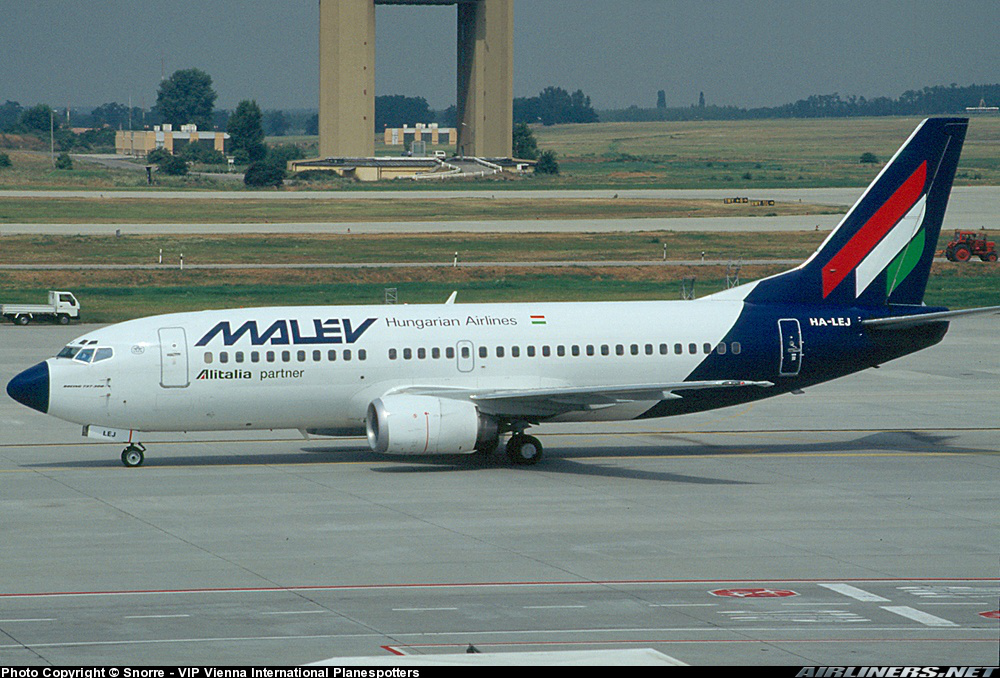

In [27]:
Image.open(real_samples[0])

In [16]:
# resize to 256x256 and make grid
real_sample_grid = make_grid(
    [torch.tensor(np.array(Image.open(real_samples[i]).resize((256, 256)))).permute(2, 0, 1) for i in range(len(real_samples))], nrow=2
)
synthetic_sample_finetuned_grid = make_grid(
    [torch.tensor(synthetic_samples_finetuned[i]).permute(2, 0, 1) for i in range(total_num_samples)], nrow=2
)
synthetic_sample_dog_grid = make_grid(
    [torch.tensor(synthetic_samples_dog[i]).permute(2, 0, 1) for i in range(total_num_samples)], nrow=2
)

In [20]:
import matplotlib.pyplot as plt

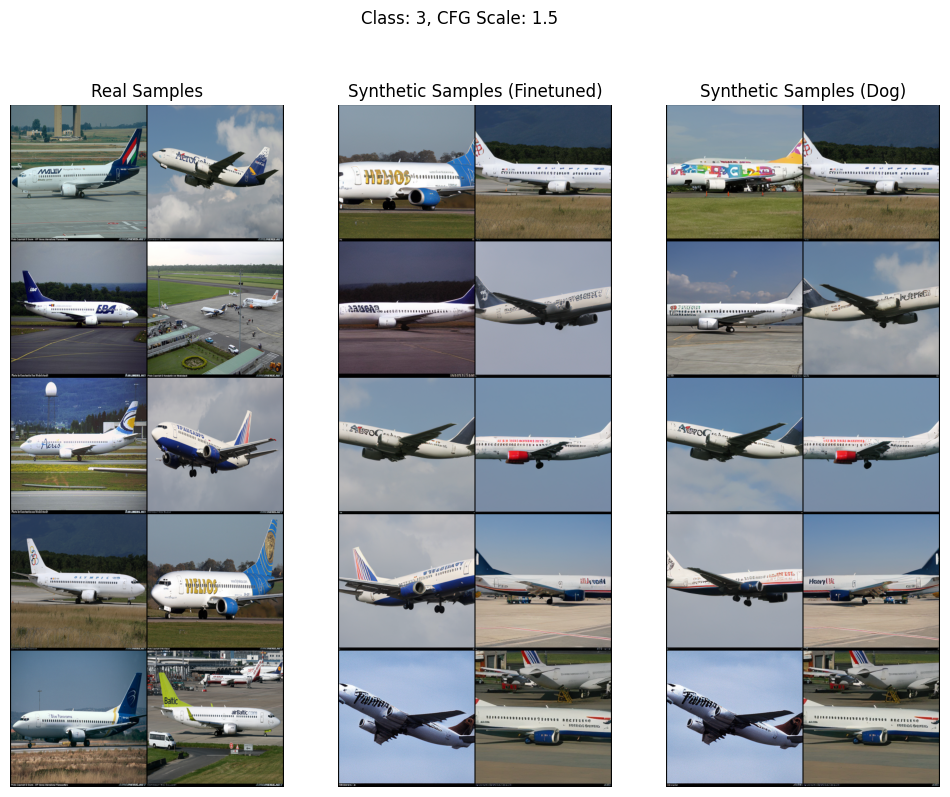

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(real_sample_grid.permute(1, 2, 0))
axs[0].set_title("Real Samples")
axs[0].axis("off")
axs[1].imshow(synthetic_sample_finetuned_grid.permute(1, 2, 0))
axs[1].set_title("Synthetic Samples (Finetuned)")
axs[1].axis("off")
axs[2].imshow(synthetic_sample_dog_grid.permute(1, 2, 0))
axs[2].set_title("Synthetic Samples (Dog)")
axs[2].axis("off")
plt.suptitle(f"Class: {target_class}, CFG Scale: {cfg_scale}")
plt.show()